## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle as pkl

In [3]:
df = pd.read_pickle('df_train_api.pk')

In [4]:
df.head()

,groups,type,data,label,coords
270,ACME VISUAL SYSTEMS,"(acm visual system, text,text,text, 2337, 1653)",14754,0,"[511.0, 143.0, 1217.0, 189.0, 864.0, 166.0]"
271,TAX INVOICE,"(tax invoic, text,text, 2337, 1653)",14754,0,"[717.0, 264.0, 877.0, 284.0, 797.0, 274.0]"
272,ACME VISUAL SYSTEMS,"(acm visual system, text,text,text, 2337, 1653)",14754,0,"[166.0, 351.0, 435.0, 369.0, 300.5, 360.0]"
273,"808, JANTA FLAT, GTB ENCLAVE, NANAD NAGARI","(number janta flat gtb enclav nanad nagari, nu...",14754,0,"[167.0, 384.0, 712.0, 403.0, 439.5, 393.5]"
274,DELHI-110093,"(delhi-110093, text, 2337, 1653)",14754,0,"[168.0, 417.0, 323.0, 436.0, 245.5, 426.5]"


In [5]:
df0 = df.query('label==0').sample(frac = 0.1)
df = df[df.label != 0]
df = pd.concat([df, df0], ignore_index=True)

In [6]:
X = df[['groups']]
X.head()

,groups
0,GS-032
1,22/08/2017
2,"Rs16,640"
3,N-10-01/2016-17
4,10-11-2017


In [7]:
y = df['label']
y.value_counts()/y.shape

0     0.632394
18    0.100000
2     0.100000
1     0.097183
14    0.039437
8     0.030986
Name: label, dtype: float64

In [8]:
from keras.preprocessing.text import Tokenizer
max_features = 4000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' ', lower=True, )
tokenizer.fit_on_texts(X['groups'].values)

X = tokenizer.texts_to_sequences(X['groups'].values)

# add padding
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen=40)


/home/jatin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Word tokenizer

In [9]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
# c_vectorizer = CountVectorizer(max_features=200)
# f_vectorizer = TfidfVectorizer()

In [11]:
# c_vectorizer.fit(df['groups'].values)

In [12]:
# X = c_vectorizer.transform(df['groups'])
# X = X.toarray()
# X = pd.DataFrame(data=X)
# X.head()

## Import PCA

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=8)

In [15]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

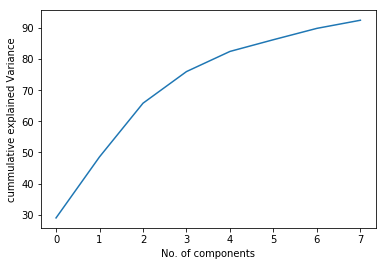

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [17]:
X_pca = pca.transform(X)

In [18]:
X_pca.shape

(710, 8)

## Train test split

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_pca)
X_pca = sc.transform(X_pca)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.25, random_state = 42)

## Evaluation function

In [20]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [21]:
def print_score(clf, X_train, X_test, y_train, y_test, train = True):
#     print accuracy score, classification report, confusion metrics
    if train:
#         training performance
        print('Train Result : \n')
        print('Accuracy Score {0:.4f}\n'.format(accuracy_score(y_train, clf.predict(X_train))))
        print('Classification Report : \n {} \n'.format(classification_report(y_train, clf.predict(X_train))))
        print('Confusion Metrics : \n {} \n'.format(confusion_matrix(y_train, clf.predict(X_train))))
        
        res = cross_val_score(clf, X_train, y_train, cv = 10, scoring='accuracy')
        print('Average Accuracy : {0:.4f}\n'.format(np.mean(res)))
        print('Accuracy SD : {0:.4f}\n'.format(np.std(res)))
        
    elif train == False:
#         test performance
        print('Test Result : \n')
        print('Accuracy Score {0:.4f}\n'.format(accuracy_score(y_test, clf.predict(X_test))))
        print('Classification Report : \n {}\n'.format(classification_report(y_test, clf.predict(X_test))))
        print('Confusion Metrics : \n {} \n'.format(confusion_matrix(y_test, clf.predict(X_test))))


## Decision Tree

In [22]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [23]:
dt_clf = DecisionTreeClassifier()

In [24]:
params = {'min_samples_split': range(2, 20),
          'min_samples_leaf': range(2, 10),
          'criterion': ['entropy', 'gini']}

In [25]:
clf = GridSearchCV(dt_clf, param_grid=params, cv=10)

In [26]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': range(2, 20), 'min_samples_leaf': range(2, 10), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.9192

Classification Report : 
              precision    recall  f1-score   support

          0       0.96      0.99      0.97       348
          1       0.90      0.88      0.89        51
          2       0.80      0.88      0.84        50
          8       0.80      0.53      0.64        15
         14       0.69      0.53      0.60        17
         18       0.87      0.76      0.81        51

avg / total       0.92      0.92      0.92       532
 

Confusion Metrics : 
 [[344   0   1   1   1   1]
 [  5  45   0   1   0   0]
 [  4   0  44   0   0   2]
 [  0   1   3   8   2   1]
 [  1   1   4   0   9   2]
 [  5   3   3   0   1  39]] 

Average Accuracy : 0.7404

Accuracy SD : 0.0276

Test Result : 

Accuracy Score 0.7360

Classification Report : 
              precision    recall  f1-score   support

          0       0.82      0.93      0.87       101
          1       0.67      0.56      0.61        18
          2       0.48      0.57      0.52  

## Using Random Forest

In [28]:
rf_clf = RandomForestClassifier()
params = {'n_estimators': [200],
          'criterion': ['entropy', 'gini'],
          'min_samples_split': range(5, 10),
          'min_samples_leaf': range(2, 10)}

In [29]:
clf = GridSearchCV(rf_clf, param_grid=params, cv=10)

In [30]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'criterion': ['entropy', 'gini'], 'min_samples_split': range(5, 10), 'min_samples_leaf': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)